# Hansen (2015) RDD Replication

## Paper summary

*Briefly summarize this paper.  What is his research question? What data does he use?  What is his research design, or “identification strategy”?  What are his conclusions?*

Hansen is interested in determining whether the sanctions on a driving under the influence (DUI) affect recidivism. The DUI is determined by the blood alcohol content (BAC). This paper uses administrative records on a 512,964 DUI stops in Washington state (WA). A BAC above 0.08 denotes a DUI and forms a sharp threshold. Hansen exploits this threshold in a sharp regression discontinuity design. 

This paper finds evidence that having a blood alcohol content about the DUI threshold reduces rates of recidivism over the next four years.

## Setup

In [2]:
install.packages("tidymodels")
install.packages("rdd")
install.packages("rdrobust")

Installing package into ‘/Users/scottcohn/Library/R/4.0/library’
(as ‘lib’ is unspecified)




The downloaded binary packages are in
	/var/folders/n2/_7r9g5mj1zvc314ypm535vjm0000gn/T//RtmpOpPV8x/downloaded_packages


Installing package into ‘/Users/scottcohn/Library/R/4.0/library’
(as ‘lib’ is unspecified)




The downloaded binary packages are in
	/var/folders/n2/_7r9g5mj1zvc314ypm535vjm0000gn/T//RtmpOpPV8x/downloaded_packages


Installing package into ‘/Users/scottcohn/Library/R/4.0/library’
(as ‘lib’ is unspecified)




The downloaded binary packages are in
	/var/folders/n2/_7r9g5mj1zvc314ypm535vjm0000gn/T//RtmpOpPV8x/downloaded_packages


In [1]:
## libs

library(tidyverse)
library(magrittr)
library(modelsummary)
library(sandwich)
library(estimatr)
library(lmtest)
library(rdd)
library(rdrobust)
library(knitr)
library(broom)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.5     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: AER

Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: survival

Loadi

In [62]:
# Remove scientific notation
options(scipen=999)

In [71]:
## funcs

read_data <- function(df)
{
  full_path <- paste("https://raw.githubusercontent.com/scottcohn97/hansen2015_RDD_replication/main/Data/", 
                     df, sep = "")
  df <- read_csv(full_path)
  return(df)
}

In [6]:
## load data

dwi <- read_data("hansen_dwi.csv")

Parsed with column specification:
cols(
  Date = col_character(),
  Alcohol1 = col_double(),
  Alcohol2 = col_double(),
  low_score = col_double(),
  male = col_double(),
  white = col_double(),
  recidivism = col_double(),
  acc = col_double(),
  aged = col_double(),
  year = col_double(),
  bac1 = col_double(),
  bac2 = col_double()
)



In [7]:
dwi %>% colnames()

[1] "Date"       "Alcohol1"   "Alcohol2"   "low_score"  "male"      
 [6] "white"      "recidivism" "acc"        "aged"       "year"      
[11] "bac1"       "bac2"

## Reproducing

*In the United States, an officer can arrest a driver if after giving them a blood alcohol content (BAC) test they learn the driver had a BAC of 0.08 or higher. We will only focus on the 0.08 BAC cutoff. We will be ignoring the 0.15 cutoff for all this analysis. Create a dummy equaling 1 if `bac1` >= 0.08 and 0 otherwise in your do file or R file*

In [8]:
## tidy

dwi <- dwi %>% 
  # create binary for cutoff
  mutate(dui = if_else(bac1 >= 0.08, 1, 0)) 

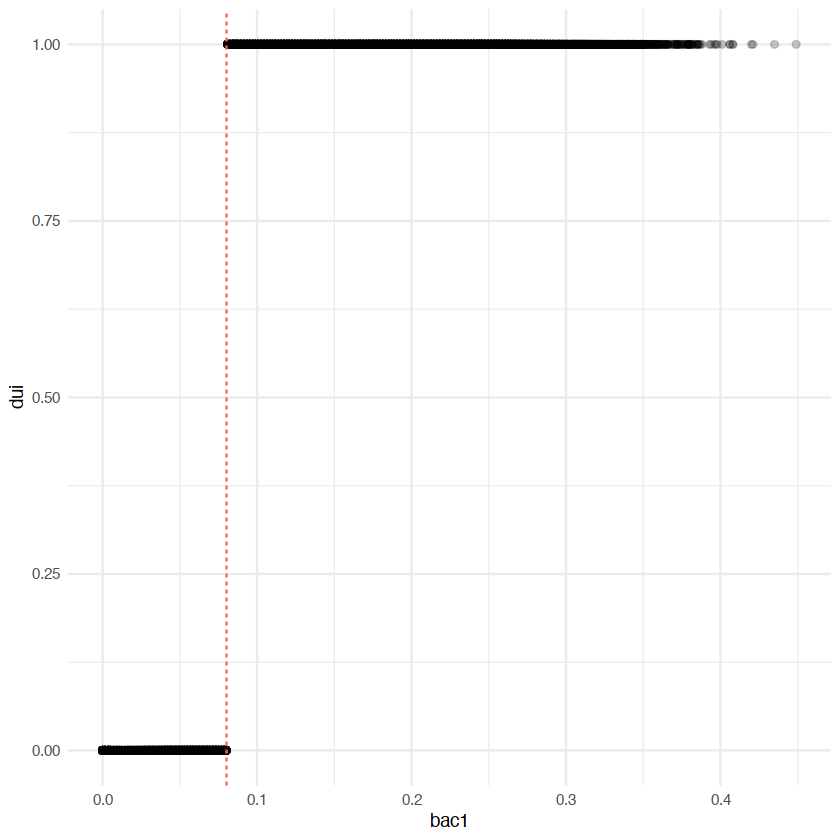

In [12]:
# visually check coding

dwi %>% 
    ggplot(aes(x = bac1, y = dui)) + 
    geom_point(alpha = 0.2) + 
    geom_vline(aes(xintercept = 0.08), linetype = 2, color = "tomato") + 
    theme_minimal()

This is a sharp RDD.

### Figure 1

*The first thing to do in any RDD is look at the raw data and see if there’s any evidence for manipulation (“sorting on the running variable”). If people were capable of manipulating their blood alcohol content (`bac1`), describe the test we would use to check for this.  Now evaluate whether you see this in these data?  Either recreate Figure 1 using the `bac1` variable as your measure of blood alcohol content or use your own density test from software.  Do you find evidence for sorting on the running variable? Explain your results.  Compare what you found to what Hansen found.*

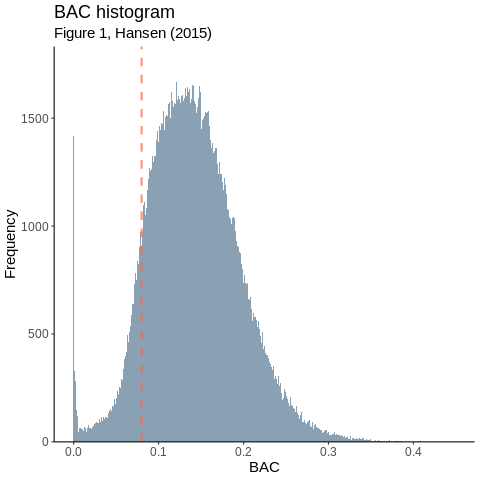

In [51]:
## Fig 1

dwi %>%
  ggplot(aes(x = bac1)) +
  geom_histogram(binwidth = 0.001, fill = "#8aa1b4") +
  geom_vline(aes(xintercept = 0.08), size = 1, linetype = 2,
             color = "tomato", alpha = 0.7) +
  labs(x = "BAC",
       y = "Frequency",
       title = "BAC histogram",
       subtitle = "Figure 1, Hansen (2015)") +
  scale_y_continuous(expand = expansion(mult = c(0, .1))) +
  theme_classic() + 
  theme(axis.text = element_text(size = 12),
        axis.title = element_text(size = 15),
        title = element_text(size = 15))

From the distribution of blood alcohol content (BAC), we see little to no evidence of endogenous sorting. There appears to be no non-random heaping that might bias the RDD. This aligns exactly with what Hansen (2015) found.

### Table 2

*The second thing we need to do is check for covariate balance. Recreate Table 2 Panel A but only white male, age and accident (`acc`) as dependent variables.  Use your equation (1) for this. Are the covariates balanced at the cutoff?  It’s okay if they are not exactly the same as Hansen’s.*

Equation 1:

$$y_i = X_i' \gamma + \alpha_1 \textrm{DUI}_i + \alpha_2 \textrm{BAC}_i \times \textrm{DUI}_i + u_i,$$

where $y_i$ is a measure of recidivism, $X_i$ is a vector of controls, and the BAC variable is rescaled around the relevant threshold.


In [ ]:
## RDD (sharp)

# allow slopes to vary
dwi_rdd <- dwi %>%
    drop_na(any_of("recidivism")) %$% 
    lm_robust(recidivism ~ white + male + aged + acc + dui + I(bac1 * dui), clusters = dui) 
    # lm(y ~ white + male + aged + acc + dui + I(bac1 - 0.001)) 

dwi_rdd %>%
    summary()

In [9]:
# optimal bandwidth -- use Imbens/Kalyanaraman bin-widths
with(dwi, IKbandwidth(bac1, recidivism, cutpoint = 0.08))

[1] 0.03667763

In [63]:
# bandwidth -- use 0.05 per the paper
bw <- 0.05

# kernel weights (rectangular)
dwi$wt <- kernelwts(dwi$bac1, center = 0.08, bw = bw, kernel = "rectangular")

# run model
rdd_lm <- lm(recidivism ~ dui + bac1 + dui * bac1 + male + white + aged + acc, 
       weights = wt, data = subset(dwi, wt > 0))

# model summary
coeftest(rdd_lm, vcov. = vcovHC(rdd_lm, type = "HC1"))


t test of coefficients:

                Estimate   Std. Error  t value              Pr(>|t|)    
(Intercept)  0.109352077  0.013144015   8.3195 < 0.00000000000000022 ***
dui         -0.059066297  0.015211067  -3.8831             0.0001032 ***
bac1        -0.042867772  0.186632224  -0.2297             0.8183323    
male         0.033180284  0.002328875  14.2473 < 0.00000000000000022 ***
white        0.016223824  0.002802436   5.7892        0.000000007096 ***
aged        -0.000853715  0.000084968 -10.0474 < 0.00000000000000022 ***
acc          0.004209609  0.003451968   1.2195             0.2226650    
dui:bac1     0.438089952  0.203797789   2.1496             0.0315871 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [101]:
rdd_rdest <- RDestimate(recidivism ~ bac1 | male + white + aged + acc, 
                        data = dwi, cutpoint = 0.08, 
                        bw = bw, 
                        kernel = "rectangular", 
                        cluster = dwi$dui,
                        model = TRUE,
                        frame = TRUE,
                        verbose = TRUE)

# See elements of model object
# https://rdrr.io/cran/rdd/man/RDestimate.html

# model summary
# summary(rdd_rdest)

Running Sharp RD
Running variable: bac1 
Outcome variable: recidivism 
Covariates: male, white, aged, acc 
Model:

Call:
lm(formula = form, data = subset(data, w > 0), weights = w)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0004790 -0.0003978 -0.0003549 -0.0002873  0.0032187 

Coefficients:
               Estimate  Std. Error t value             Pr(>|t|)    
(Intercept)  0.10592265  0.00554156  19.114 < 0.0000000000000002 ***
Tr          -0.02401910  0.00430895  -5.574         0.0000000249 ***
Xl          -0.04286777  0.18256307  -0.235                0.814    
Xr           0.39522218  0.08238364   4.797         0.0000016104 ***
male         0.03318028  0.00253573  13.085 < 0.0000000000000002 ***
white        0.01622382  0.00290867   5.578         0.0000000244 ***
aged        -0.00085371  0.00008912  -9.579 < 0.0000000000000002 ***
acc          0.00420961  0.00341597   1.232                0.218    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.

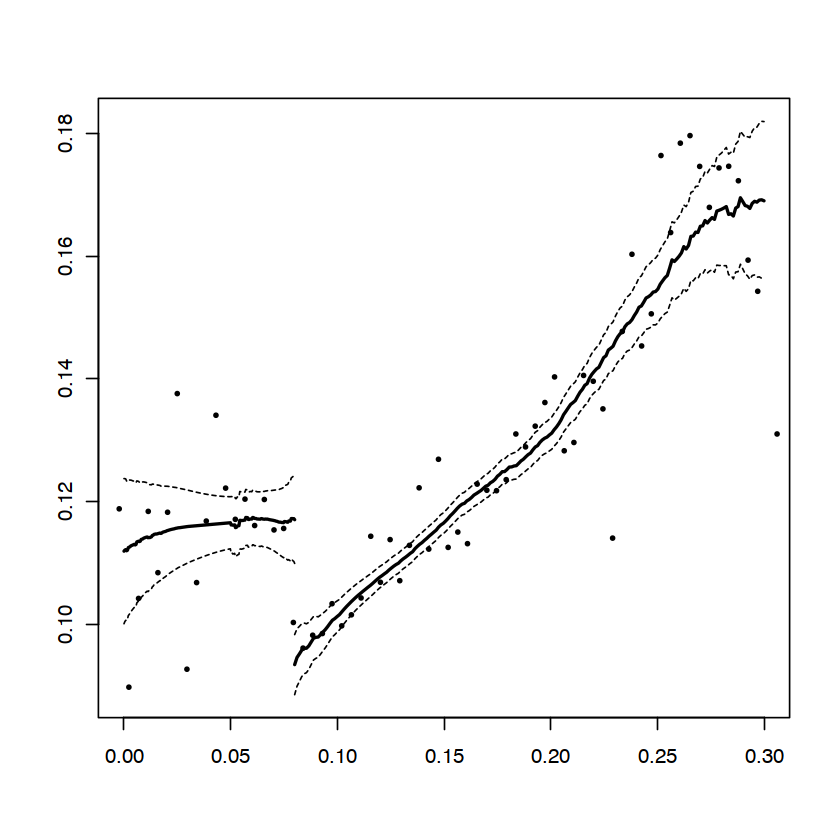

In [79]:
plot(rdd_rdest, which = 1, range = c(0, 0.3))

In [125]:
as_tibble(rdd_rdest[["frame"]][1]) %>% 
    fortify() %>%
    ggplot(aes(x = X, y = Y)) + 
    geom_point(aes(color = Y)) #+ 
     #geom_smooth(method = "lm", 
      #           aes(y=predict(rdd_rdest[["model"]][1], rdd_rdest[["frame"]]))) 

ERROR: Error: Column 1 must be named.


In [112]:
rdd_rdest[["frame"]] %>% head()

,X,Y,male,white,aged,acc
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,1,1,48,0
2,0,0,1,1,51,0
3,0,0,1,0,68,0
4,0,0,1,1,51,0
5,0,0,1,1,22,0
6,0,0,1,1,49,1
7,0,1,1,0,63,0
8,0,0,0,0,49,0
9,0,0,0,1,21,0


In [61]:
## Table 2

# modelsummary()

ERROR: Error in modelsummary_wide(dwi_rdd): could not find function "modelsummary_wide"


### Figure 2 Panels A-D

*Recreate Figure 2 panel A-D. You can use the -cmogram- command in Stata to do this. Fit both linear and quadratic with confidence intervals. Discuss what you find and compare it with Hansen’s paper.*

TODO Add CI intervals!

Warning message:
“Removed 21743 rows containing missing values (geom_point).”


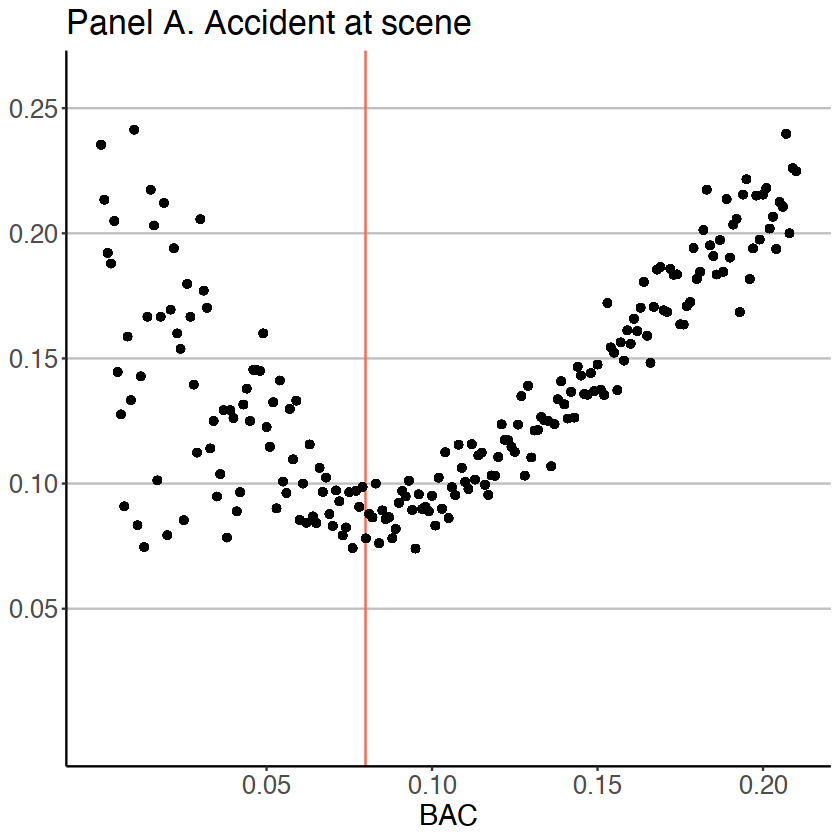

In [28]:
# Figure 2 Panel A - Accident at scene

dwi %>%
    group_by(bac1) %>%
    mutate(avg_acc = mean(acc)) %>%
    ggplot(aes(x = bac1, y = avg_acc)) + 
    geom_vline(aes(xintercept = 0.08), color = "tomato") +
    geom_point(alpha = 0.3, fill = "white") + 
    # geom_smooth( FITTED LINE ) +
    scale_x_continuous(name = "BAC", limits = c(0, 0.21), breaks = c(0.05, 0.1, 0.15, 0.2)) + 
    scale_y_continuous(limits = c(0, 0.26), breaks = c(0.05, 0.1, 0.15, 0.2, 0.25)) + 
    labs(title = "Panel A. Accident at scene") +
    theme_classic() + 
    theme(panel.grid.major.y = element_line(color = "grey", size=0.5),
          plot.title = element_text(size=20),
          axis.text.x = element_text(size = 15),
          axis.title.x = element_text(size = 17),
          axis.text.y = element_text(size = 15),
          axis.title.y = element_blank())

Warning message:
“Removed 24555 rows containing missing values (geom_point).”


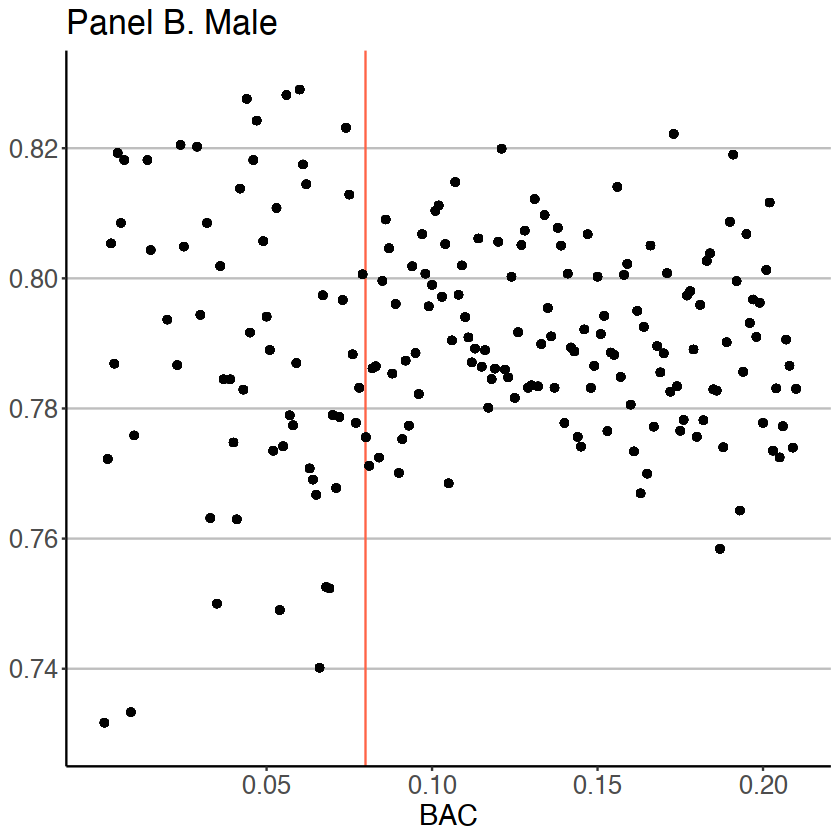

In [29]:
# Figure 2 Panel B - Male

dwi %>%
    group_by(bac1) %>%
    mutate(avg_male = mean(male)) %>%
    ggplot(aes(x = bac1, y = avg_male)) + 
    geom_vline(aes(xintercept = 0.08), color = "tomato") +
    geom_point(alpha = 0.3, fill = "white") + 
    # geom_smooth( FITTED LINE ) +
    scale_x_continuous(name = "BAC", limits = c(0, 0.21), breaks = c(0.05, 0.1, 0.15, 0.2)) + 
    scale_y_continuous(limits = c(0.73, 0.83), breaks = c(0.74, 0.76, 0.78, 0.8, 0.82)) + 
    labs(title = "Panel B. Male") +
    theme_classic() + 
    theme(panel.grid.major.y = element_line(color = "grey", size=0.5),
          plot.title = element_text(size=20),
          axis.text.x = element_text(size = 15),
          axis.title.x = element_text(size = 17),
          axis.text.y = element_text(size = 15),
          axis.title.y = element_blank())

Warning message:
“Removed 22173 rows containing missing values (geom_point).”


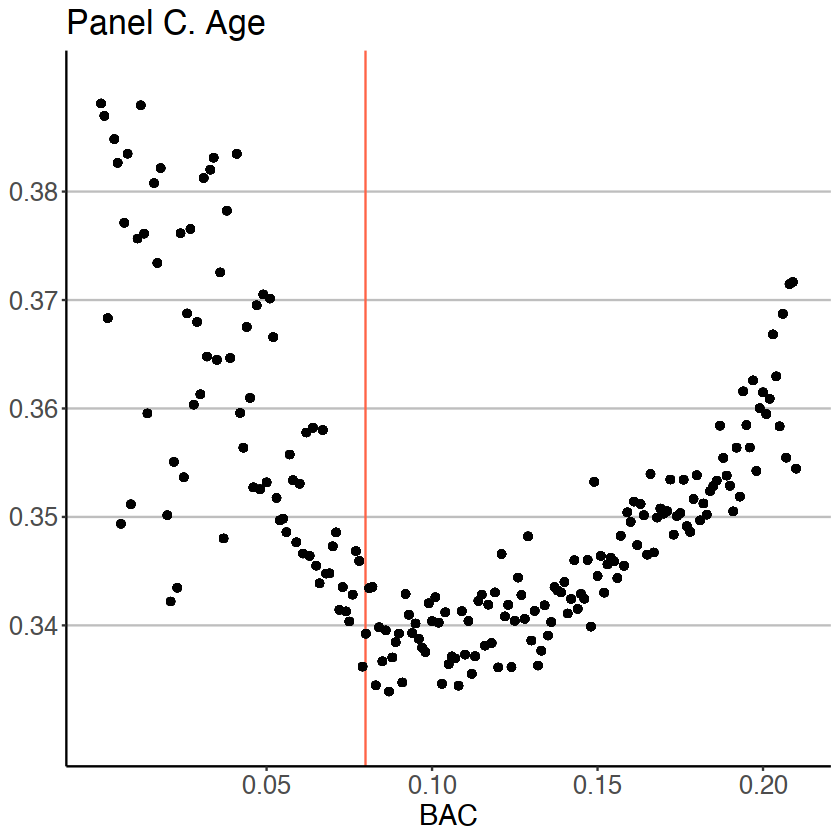

In [37]:
# Figure 2 Panel C - Age

dwi %>%
    group_by(bac1) %>%
    mutate(avg_age = mean(aged / 100)) %>%
    ggplot(aes(x = bac1, y = avg_age)) + 
    geom_vline(aes(xintercept = 0.08), color = "tomato") +
    geom_point(alpha = 0.3, fill = "white") + 
    # geom_smooth( FITTED LINE ) +
    scale_x_continuous(name = "BAC", limits = c(0, 0.21), breaks = c(0.05, 0.1, 0.15, 0.2)) + 
    scale_y_continuous(limits = c(0.33, 0.39), breaks = c(0.34, 0.35, 0.36, 0.37, 0.38)) + 
    labs(title = "Panel C. Age") +
    theme_classic() + 
    theme(panel.grid.major.y = element_line(color = "grey", size=0.5),
          plot.title = element_text(size=20),
          axis.text.x = element_text(size = 15),
          axis.title.x = element_text(size = 17),
          axis.text.y = element_text(size = 15),
          axis.title.y = element_blank())

Warning message:
“Removed 22148 rows containing missing values (geom_point).”


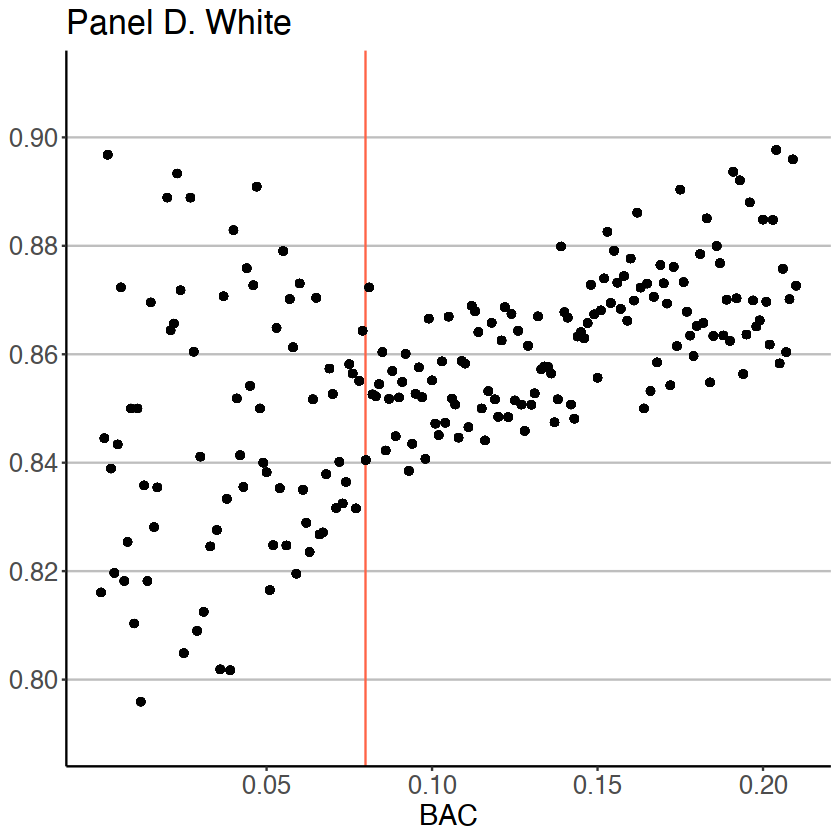

In [40]:
# Figure 2 Panel D - White

dwi %>%
    group_by(bac1) %>%
    mutate(avg_white = mean(white)) %>%
    ggplot(aes(x = bac1, y = avg_white)) + 
    geom_vline(aes(xintercept = 0.08), color = "tomato") +
    geom_point(alpha = 0.3, fill = "white") + 
    # geom_smooth( FITTED LINE ) +
    scale_x_continuous(name = "BAC", limits = c(0, 0.21), breaks = c(0.05, 0.1, 0.15, 0.2)) + 
    scale_y_continuous(limits = c(0.79, 0.91), breaks = c(0.80, 0.82, 0.84, 0.86, 0.88, 0.90)) + 
    labs(title = "Panel D. White") +
    theme_classic() + 
    theme(panel.grid.major.y = element_line(color = "grey", size=0.5),
          plot.title = element_text(size=20),
          axis.text.x = element_text(size = 15),
          axis.title.x = element_text(size = 17),
          axis.text.y = element_text(size = 15),
          axis.title.y = element_blank())

### Table 3, Col 1, Panel A + B

*Estimate equation (1) with recidivism (`recid`) as the outcome. This corresponds to Table 3 column 1, but since I am missing some of his variables, your sample size will be the entire dataset of 214,558. Nevertheless, replicate Table 3, column 1, Panels A and B.  Note that these are local linear regressions and Panel A uses as its bandwidth 0.03 to 0.13.  But Panel B has a narrower bandwidth of 0.055 to 0.105.  Your table should have three columns and two A and B panels associated with the different bandwidths.:*

1. *Column 1: control for the `bac1` linearly*
2. *Column 2: interact `bac1` with cutoff linearly*
3. *Column 3: interact `bac1` with cutoff linearly and as a quadratic*
4. *For all analysis, estimate uncertainty using heteroskedastic robust standard errors. [ed: But if you want to show off, use Kolesár and Rothe’s 2018 “honest” confidence intervals (only available in R).]*


#### Panel A

Panel A contains estimates with a bandwidth of 0.05, with all regressions utilizing a rectangular kernel for weighting.

In [49]:
# kernel weights (rectangular)
dwi$wt_3A <- kernelwts(dwi$bac1, center = 0.08, bw = 0.05, kernel = "rectangular")

In [50]:
# column 1 -- control for bac1 linearly
model_3a1 <- lm_robust(recidivism ~ dui + bac1 + dui * bac1 + year + male + white + aged, 
                       weights = wt_3A, data = subset(dwi, wt_3A > 0))

# model summary
summary(model_3a1)


Call:
lm_robust(formula = recidivism ~ dui + bac1 + dui * bac1 + year + 
    male + white + aged, data = subset(dwi, wt_3A > 0), weights = wt_3A)

Weighted, Standard error type:  HC2 

Coefficients:
              Estimate Std. Error  t value  Pr(>|t|)  CI Lower   CI Upper    DF
(Intercept)  5.4497619  8.234e-01   6.6189 3.639e-11  3.835980  7.0635442 89959
dui         -0.0582135  1.521e-02  -3.8263 1.302e-04 -0.088033 -0.0283943 89959
bac1        -0.0411081  1.867e-01  -0.2202 8.257e-01 -0.407045  0.3248285 89959
year        -0.0026646  4.109e-04  -6.4853 8.899e-11 -0.003470 -0.0018593 89959
male         0.0325301  2.330e-03  13.9623 2.944e-44  0.027964  0.0370966 89959
white        0.0145230  2.818e-03   5.1535 2.563e-07  0.009000  0.0200464 89959
aged        -0.0008553  8.481e-05 -10.0849 6.634e-24 -0.001022 -0.0006891 89959
dui:bac1     0.4281776  2.038e-01   2.1005 3.569e-02  0.028643  0.8277118 89959

Multiple R-squared:  0.004089 ,	Adjusted R-squared:  0.004011 
F-statistic: 57.

In [ ]:
# column 2 -- contorl for bac1 with cutoff linearly

In [ ]:
# column 3 -- interact bac1 with cutoff linearly and as quadratic

#### Panel B

Panel B contains estimates with a bandwidth of 0.025, with all regressions utilizing a rectangular kernel for weighting.

In [51]:
# kernel weights (rectangular)
dwi$wt_3B <- kernelwts(dwi$bac1, center = 0.08, bw = 0.025, kernel = "rectangular")

In [52]:
model_3b1 <- lm_robust(recidivism ~ dui + bac1 + dui * bac1 + year + male + white + aged, 
                       weights = wt_3B, data = subset(dwi, wt_3B > 0))

# model summary
summary(model_3b1)


Call:
lm_robust(formula = recidivism ~ dui + bac1 + dui * bac1 + year + 
    male + white + aged, data = subset(dwi, wt_3B > 0), weights = wt_3B)

Weighted, Standard error type:  HC2 

Coefficients:
              Estimate Std. Error t value  Pr(>|t|)   CI Lower  CI Upper    DF
(Intercept)  5.9214595  1.1340231  5.2216 1.781e-07  3.6987581  8.144161 47197
dui         -0.0683247  0.0342139 -1.9970 4.583e-02 -0.1353843 -0.001265 47197
bac1        -0.2669310  0.3690772 -0.7232 4.695e-01 -0.9903275  0.456466 47197
year        -0.0028950  0.0005655 -5.1192 3.081e-07 -0.0040034 -0.001787 47197
male         0.0347427  0.0031644 10.9793 5.197e-28  0.0285405  0.040945 47197
white        0.0155514  0.0038299  4.0605 4.905e-05  0.0080447  0.023058 47197
aged        -0.0007701  0.0001148 -6.7068 2.012e-11 -0.0009952 -0.000545 47197
dui:bac1     0.6045180  0.4378663  1.3806 1.674e-01 -0.2537062  1.462742 47197

Multiple R-squared:  0.004552 ,	Adjusted R-squared:  0.004404 
F-statistic:  33.1 on 7 a

### Figure 3

*Recreate the top panel of Figure 3 according to the following rule:*

1. *Fit linear fit using only observations with less than 0.15 bac on the `bac1`*
2. *Fit quadratic fit using only observations with less than 0.15 bac on the `bac1`*

In [ ]:
# kernel weights (rectangular)
dwi$wt_f3B <- kernelwts(dwi$bac1, center = 0.15, bw = 0.002, kernel = "rectangular")

Warning message:
“Removed 22148 rows containing missing values (geom_point).”


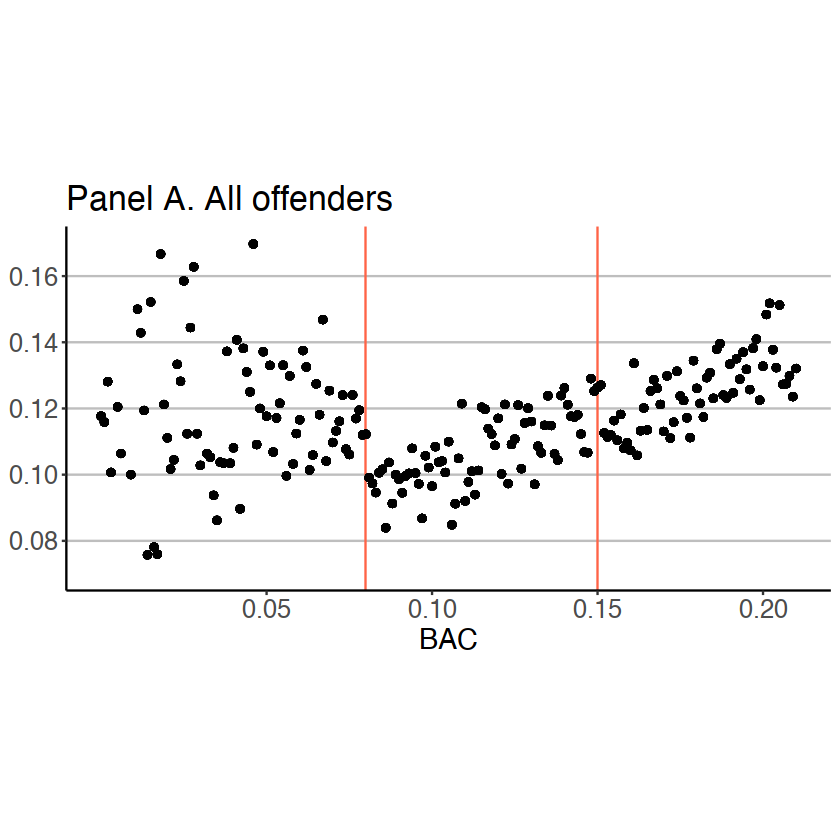

In [56]:
# Panel A. All offenders

dwi %>%
    group_by(bac1) %>%
    mutate(avg_rec = mean(recidivism)) %>%
    ggplot(aes(x = bac1, y = avg_rec)) + 
    geom_vline(aes(xintercept = 0.08), color = "tomato") +
    geom_vline(aes(xintercept = 0.15), color = "tomato") +
    geom_point(alpha = 0.3, fill = "white") + 
    # geom_smooth( FITTED LINE ) +
    scale_x_continuous(name = "BAC", limits = c(0, 0.21), breaks = c(0.05, 0.1, 0.15, 0.2)) + 
    scale_y_continuous(limits = c(0.07, 0.17), breaks = c(0.08, 0.1, 0.12, 0.14, 0.16)) + 
    labs(title = "Panel A. All offenders") +
    theme_classic() + 
    theme(panel.grid.major.y = element_line(color = "grey", size=0.5),
          plot.title = element_text(size=20),
          axis.text.x = element_text(size = 15),
          axis.title.x = element_text(size = 17),
          axis.text.y = element_text(size = 15),
          axis.title.y = element_blank()) +
    coord_fixed()

### Reflecting on exercise

*Discuss what you learned from this exercise. What was the hypothesis you tested and what did you find?  How confident are you in Hansen’s original conclusion? Why/why not?*